<center><h1> Next-day Stock Price Forecasting using LSTM model with Pytorch</h1></center>  

Goal: Predict next-day close price for AAPL stock (daily regression)
Dataset: Daily OHLCV from Yahoo Finance, last 5 years (~1250 rows)
Pipeline: CSV download → preprocessing → train/test split → feature engineering → model → deployment
Serving & scaling: Expose API in Streamlit, handle multiple users
Monitoring: Track MAE/RMSE on latest predictions, detect drift
Tradeoffs & retraining: Decide update frequency (weekly/monthly), adjust features or model if performance drops  


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

In [4]:
# Load the CSV file
df = pd.read_csv("AAPL_5y_daily.csv", index_col=0, parse_dates=True)
df = df.rename(columns={'Adj Close': 'Adj_Close'})

# Create target column (next-day Adj_Close)
df['Target'] = df['Adj_Close'].shift(-1)
df = df.dropna()

# Features
features = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

In [6]:
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train = df.iloc[:train_size]
val = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 1004, Val: 125, Test: 126


In [8]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train[features])
y_train = scaler_y.fit_transform(train[['Target']])

X_val = scaler_X.transform(val[features])
y_val = scaler_y.transform(val[['Target']])

X_test = scaler_X.transform(test[features])
y_test = scaler_y.transform(test[['Target']])


In [10]:
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val_seq, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)


In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last time step
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = LSTMModel(input_dim=len(features), hidden_dim=64, num_layers=2, output_dim=1).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
epochs = 60
best_val_loss = float("inf")
patience, wait = 10, 0

for epoch in range(epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.6f} | Val Loss: {val_loss:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_lstm_model.pth")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break



Epoch 1/60 | Train Loss: 0.062449 | Val Loss: 0.120107
Epoch 2/60 | Train Loss: 0.008275 | Val Loss: 0.005919
Epoch 3/60 | Train Loss: 0.003460 | Val Loss: 0.005923
Epoch 4/60 | Train Loss: 0.002852 | Val Loss: 0.005981
Epoch 5/60 | Train Loss: 0.002755 | Val Loss: 0.004850
Epoch 6/60 | Train Loss: 0.002391 | Val Loss: 0.004655
Epoch 7/60 | Train Loss: 0.002322 | Val Loss: 0.004568
Epoch 8/60 | Train Loss: 0.002145 | Val Loss: 0.004796
Epoch 9/60 | Train Loss: 0.002238 | Val Loss: 0.004310
Epoch 10/60 | Train Loss: 0.002018 | Val Loss: 0.004226
Epoch 11/60 | Train Loss: 0.002007 | Val Loss: 0.004170
Epoch 12/60 | Train Loss: 0.001979 | Val Loss: 0.004859
Epoch 13/60 | Train Loss: 0.001920 | Val Loss: 0.004764
Epoch 14/60 | Train Loss: 0.001846 | Val Loss: 0.005010
Epoch 15/60 | Train Loss: 0.001926 | Val Loss: 0.004590
Epoch 16/60 | Train Loss: 0.001814 | Val Loss: 0.004147
Epoch 17/60 | Train Loss: 0.001859 | Val Loss: 0.003706
Epoch 18/60 | Train Loss: 0.001801 | Val Loss: 0.003534
E

Test RMSE: 6.917
Test MAE: 5.310


/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_6982/3013179017.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_mo

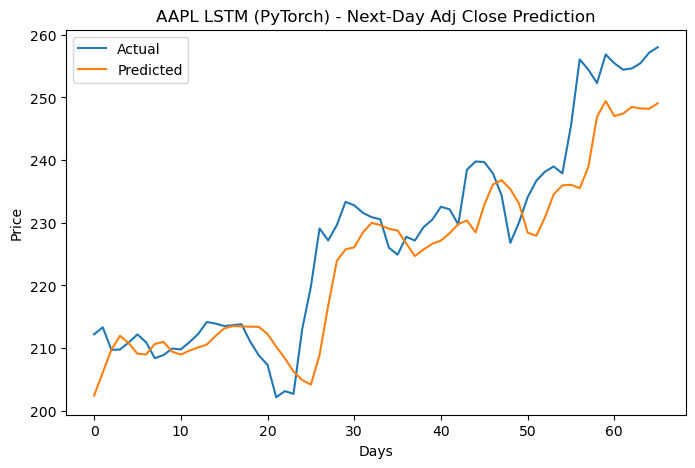

In [18]:
model.load_state_dict(torch.load("best_lstm_model.pth"))
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_test_inv = scaler_y.inverse_transform(y_test_seq)
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")

plt.figure(figsize=(8,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("AAPL LSTM (PyTorch) - Next-Day Adj Close Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [22]:
last_60_days = X_test_seq[-1:]
last_60_days_t = torch.tensor(last_60_days, dtype=torch.float32).to(device)
with torch.no_grad():
    next_day_scaled = model(last_60_days_t).cpu().numpy()
next_day_pred = scaler_y.inverse_transform(next_day_scaled)
print(f"Predicted next-day Adj Close: ${next_day_pred[0][0]:.2f}")

Predicted next-day Adj Close: $249.07


### timestep=60:   
Test RMSE: 6.917  
Test MAE: 5.310
